In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/5'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    df['cpu'] = 2*df['node'] + df['core']%2
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['size_product'] = df.m * df.n * df.k

print(len(df))
df.head()

8640000


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,cpu,size_product
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,0,4,60720
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,0,4,60720
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,0,4,60720
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,0,4,460
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,0,4,460


In [2]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

## Classical regression

We fix the intercept by hand, otherwise it gets too high.

In [3]:
from statsmodels.formula.api import ols

def compute_reg(df):
    short_calls = df[df.size_product == df.size_product.min()]
    short_calls = short_calls[short_calls.duration < short_calls.duration.quantile(0.95)]  # removing the 5% longest calls, we have very large outliers (without this, the intercept is 3 times larger)
    intercept = short_calls.duration.mean()
    tmp = pandas.DataFrame(dict(size_product = df.size_product, duration=df.duration-intercept))
    reg = ols(formula='duration ~ size_product + 0', data=df).fit()
    return {'intercept': intercept, 'coefficient': reg.params.size_product}

reg_global = compute_reg(df.sample(n=1000))
reg_global

{'intercept': 4.2312499999999997e-07, 'coefficient': 6.830373765711316e-11}

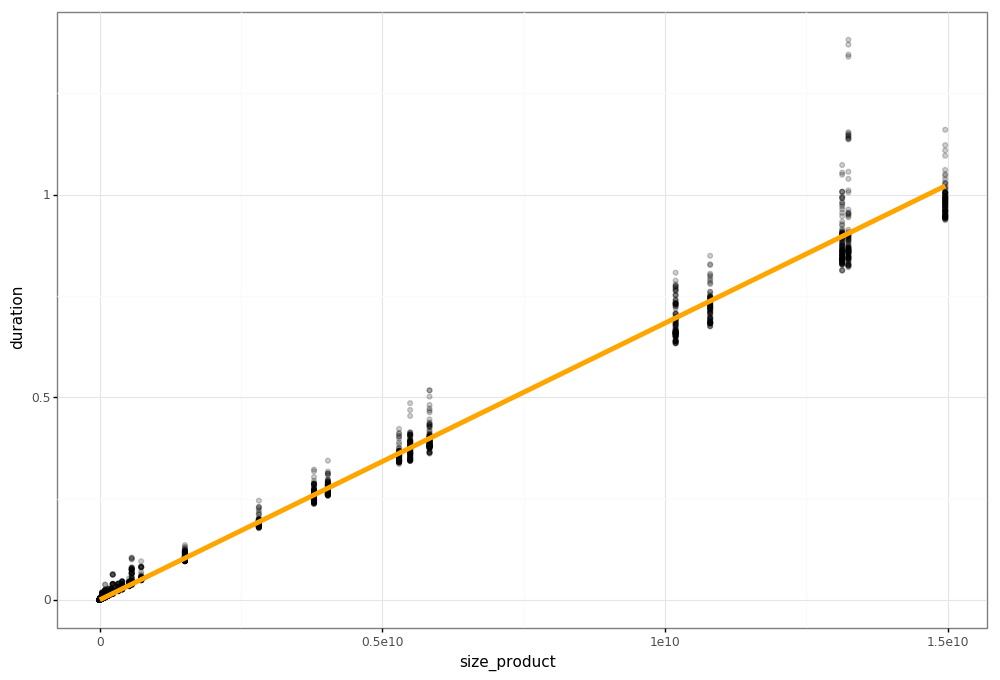

<ggplot: (-9223363269350287977)>


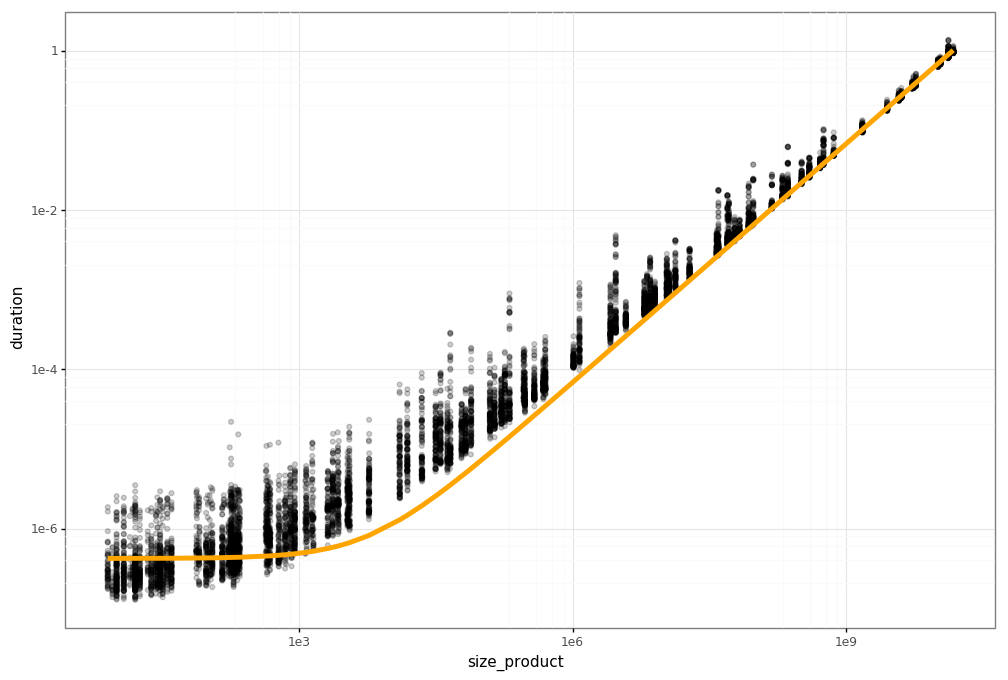

<ggplot: (-9223363269350382781)>


In [4]:
df['pred_global'] = df['size_product'] * reg_global['coefficient'] + reg_global['intercept']
plot = ggplot(df.sample(n=10000), aes(x='size_product', y='duration')) + geom_point(alpha=0.2) + geom_line(aes(y='pred_global'), color='orange', size=2) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

## Regression per CPU

In [5]:
reg_local = []
for cpu in sorted(df['cpu'].unique()):
    tmp = df[df['cpu'] == cpu] 
    reg = compute_reg(tmp)
    reg['node'] = tmp['node'].unique()[0]
    reg['cpu'] = cpu
    reg_local.append(reg)
reg_local = pandas.DataFrame(reg_local)
reg_local

,coefficient,cpu,intercept,node
0,6.807397e-11,2,3.546561e-07,1
1,6.641797e-11,3,3.398073e-07,1
2,6.698293e-11,4,3.596622e-07,2
3,6.667782e-11,5,3.547378e-07,2
4,6.697454e-11,6,3.493171e-07,3
5,6.641616e-11,7,3.379890e-07,3
6,6.638124e-11,8,3.451404e-07,4
7,6.661587e-11,9,3.372329e-07,4
8,6.861961e-11,12,3.468098e-07,6
9,6.610015e-11,13,3.436463e-07,6


In [6]:
def __return_stmt(intercept, coefficient):
    return '        return %e + %e*size;' % (intercept, coefficient)

def __reg_to_c(reg_row):
    return '''    case %d: // node %d\n%s''' % (reg_row.cpu, reg_row.node, __return_stmt(reg_row.intercept, reg_row.coefficient))

def reg_to_c(reg):
    result = [__reg_to_c(row[1]) for row in reg.iterrows()]
    return '\n'.join(result)

reg_code = reg_to_c(reg_local)
reg_code = 'switch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, __return_stmt(reg_global['intercept'], reg_global['coefficient']))

from IPython.display import Markdown, display
display(Markdown('```c\n%s\n```' % reg_code))

```c
switch(get_cpuid()) {
    case 2: // node 1
        return 3.546561e-07 + 6.807397e-11*size;
    case 3: // node 1
        return 3.398073e-07 + 6.641797e-11*size;
    case 4: // node 2
        return 3.596622e-07 + 6.698293e-11*size;
    case 5: // node 2
        return 3.547378e-07 + 6.667782e-11*size;
    case 6: // node 3
        return 3.493171e-07 + 6.697454e-11*size;
    case 7: // node 3
        return 3.379890e-07 + 6.641616e-11*size;
    case 8: // node 4
        return 3.451404e-07 + 6.638124e-11*size;
    case 9: // node 4
        return 3.372329e-07 + 6.661587e-11*size;
    case 12: // node 6
        return 3.468098e-07 + 6.861961e-11*size;
    case 13: // node 6
        return 3.436463e-07 + 6.610015e-11*size;
    case 14: // node 7
        return 3.590073e-07 + 6.657339e-11*size;
    case 15: // node 7
        return 3.347073e-07 + 6.585625e-11*size;
    case 16: // node 8
        return 3.492415e-07 + 6.766002e-11*size;
    case 17: // node 8
        return 3.457256e-07 + 6.638352e-11*size;
    case 18: // node 9
        return 3.410878e-07 + 6.632671e-11*size;
    case 19: // node 9
        return 3.365561e-07 + 6.632760e-11*size;
    case 20: // node 10
        return 3.487378e-07 + 6.638031e-11*size;
    case 21: // node 10
        return 3.600744e-07 + 6.658047e-11*size;
    case 22: // node 11
        return 3.468634e-07 + 6.616427e-11*size;
    case 23: // node 11
        return 3.393402e-07 + 6.719891e-11*size;
    case 24: // node 12
        return 3.318695e-07 + 6.639150e-11*size;
    case 25: // node 12
        return 3.413890e-07 + 6.618983e-11*size;
    case 26: // node 13
        return 3.906366e-07 + 7.442632e-11*size;
    case 27: // node 13
        return 3.645280e-07 + 7.203503e-11*size;
    case 28: // node 14
        return 3.826305e-07 + 7.423081e-11*size;
    case 29: // node 14
        return 3.760951e-07 + 7.374749e-11*size;
    case 30: // node 15
        return 3.864439e-07 + 7.917192e-11*size;
    case 31: // node 15
        return 3.790341e-07 + 7.618639e-11*size;
    case 32: // node 16
        return 3.850256e-07 + 7.559685e-11*size;
    case 33: // node 16
        return 3.763220e-07 + 7.416173e-11*size;
    case 34: // node 17
        return 3.529659e-07 + 6.878189e-11*size;
    case 35: // node 17
        return 3.415317e-07 + 6.660920e-11*size;
    case 36: // node 18
        return 3.562049e-07 + 6.845888e-11*size;
    case 37: // node 18
        return 3.289268e-07 + 6.609228e-11*size;
    case 38: // node 19
        return 3.459317e-07 + 6.661061e-11*size;
    case 39: // node 19
        return 3.418549e-07 + 6.642127e-11*size;
    case 40: // node 20
        return 3.437598e-07 + 6.667771e-11*size;
    case 41: // node 20
        return 3.399098e-07 + 6.637335e-11*size;
    case 42: // node 21
        return 3.420780e-07 + 6.667580e-11*size;
    case 43: // node 21
        return 3.365366e-07 + 6.653883e-11*size;
    case 44: // node 22
        return 3.423939e-07 + 6.628641e-11*size;
    case 45: // node 22
        return 3.499963e-07 + 6.647966e-11*size;
    case 46: // node 23
        return 3.354049e-07 + 6.663301e-11*size;
    case 47: // node 23
        return 3.411463e-07 + 6.611017e-11*size;
    case 48: // node 24
        return 3.323646e-07 + 6.644631e-11*size;
    case 49: // node 24
        return 3.346537e-07 + 6.631977e-11*size;
    case 50: // node 25
        return 3.679915e-07 + 7.152834e-11*size;
    case 51: // node 25
        return 3.283049e-07 + 6.597959e-11*size;
    case 52: // node 26
        return 3.605927e-07 + 6.667990e-11*size;
    case 53: // node 26
        return 3.494646e-07 + 6.696905e-11*size;
    case 54: // node 27
        return 3.609488e-07 + 6.690477e-11*size;
    case 55: // node 27
        return 3.422329e-07 + 6.709007e-11*size;
    case 58: // node 29
        return 3.362146e-07 + 6.655729e-11*size;
    case 59: // node 29
        return 3.507622e-07 + 6.667698e-11*size;
    case 60: // node 30
        return 3.443854e-07 + 6.644349e-11*size;
    case 61: // node 30
        return 3.370256e-07 + 6.636598e-11*size;
    case 62: // node 31
        return 3.354207e-07 + 6.618184e-11*size;
    case 63: // node 31
        return 3.398659e-07 + 6.637357e-11*size;
    case 64: // node 32
        return 3.470720e-07 + 6.608009e-11*size;
    case 65: // node 32
        return 3.401402e-07 + 6.616325e-11*size;
    default:
        return 4.231250e-07 + 6.830374e-11*size;
}
```

### Visualization

In [7]:
df['pred_local'] = -1
for cpu in df['cpu'].unique():
    reg = reg_local[reg_local['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    df.loc[df['cpu'] == cpu, 'pred_local'] = df['size_product']*reg.coefficient + reg.intercept

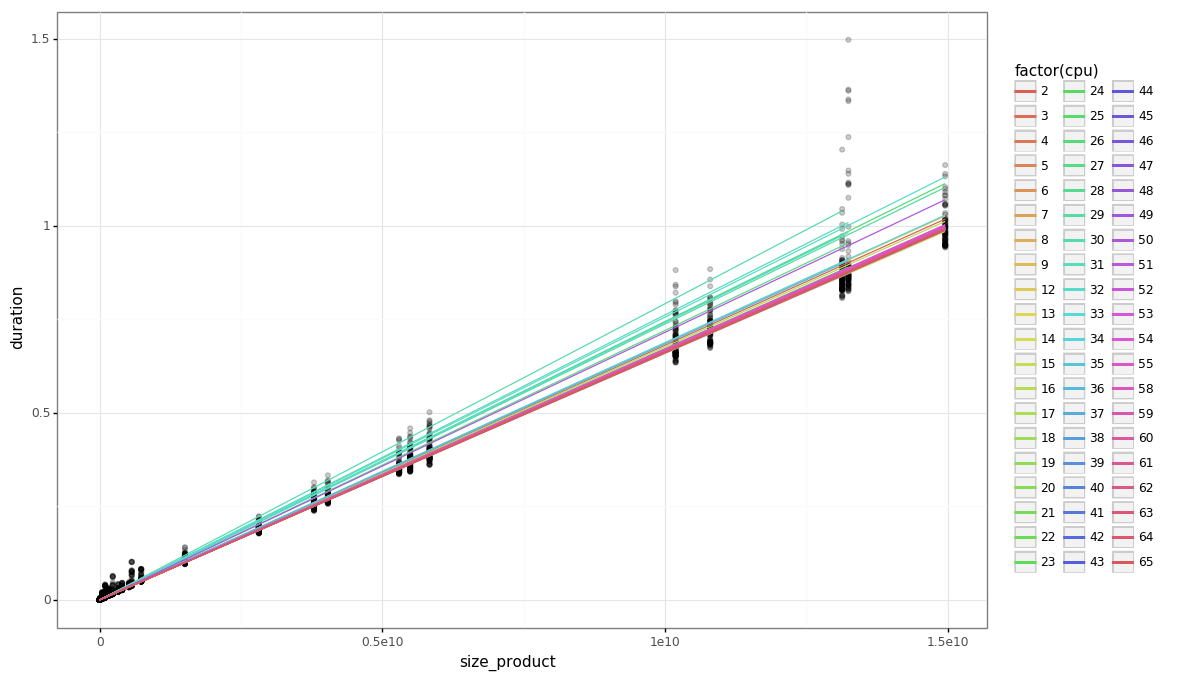

<ggplot: (8767503243619)>


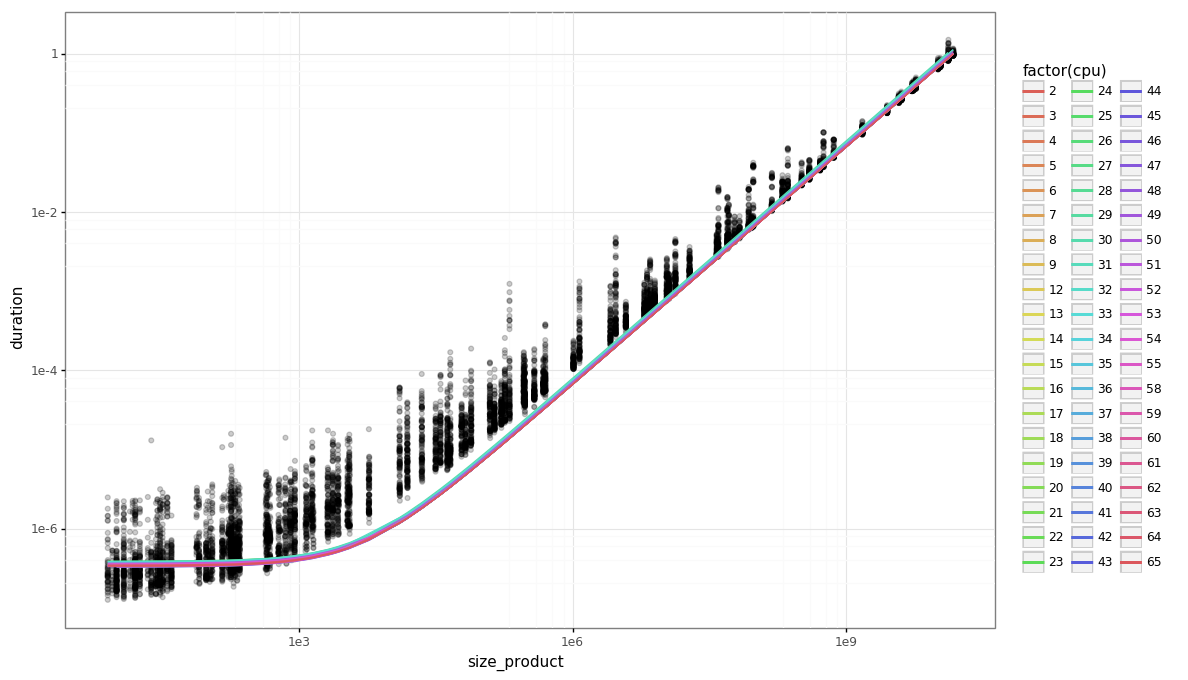

<ggplot: (8767503267809)>


In [8]:
plot = ggplot(df.sample(n=10000), aes(x='size_product', y='duration')) + geom_point(alpha=0.2) + geom_line(aes(y='pred_local', color='factor(cpu)')) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 35'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


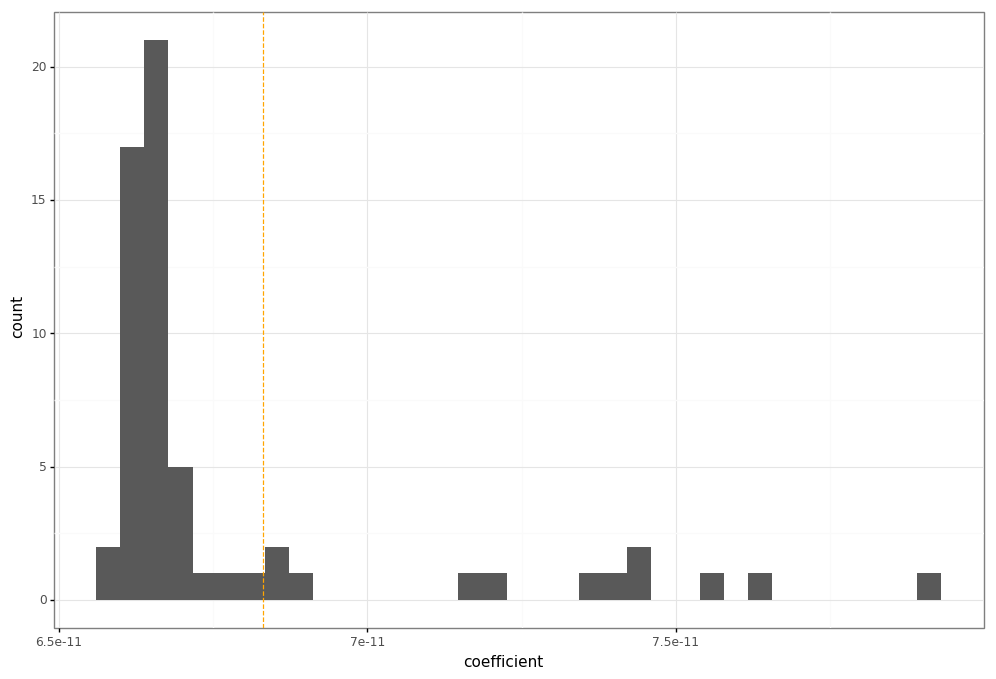

<ggplot: (-9223363269351507701)>

In [9]:
ggplot(reg_local, aes(x='coefficient')) + geom_histogram() + theme_bw() + geom_vline(xintercept=reg_global['coefficient'], linetype='dashed', color='orange')

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


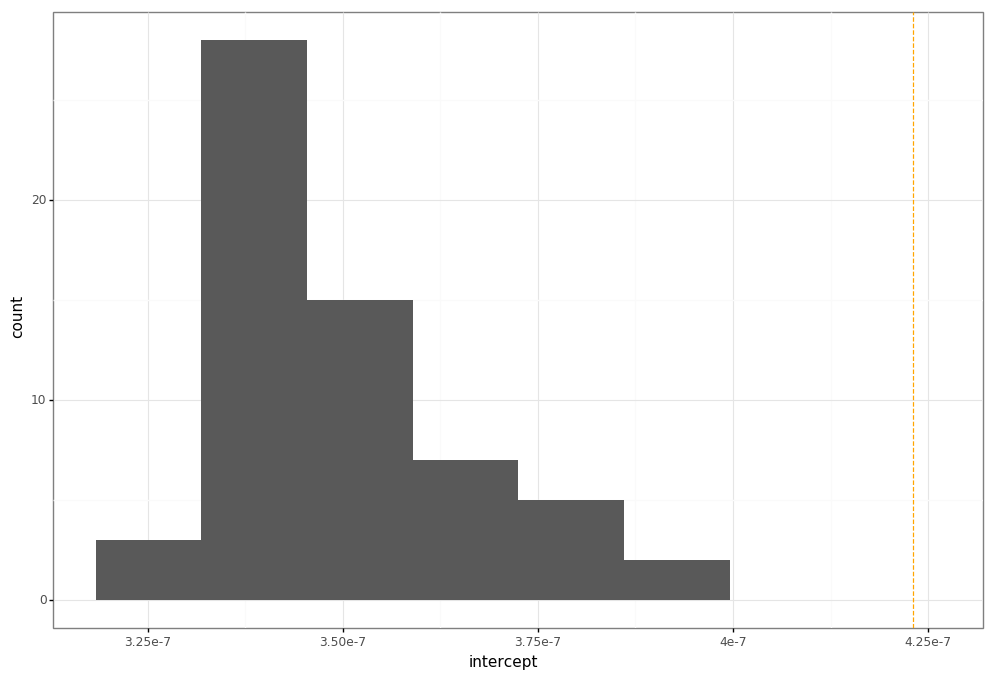

<ggplot: (-9223363269351520950)>

In [10]:
ggplot(reg_local, aes(x='intercept')) + geom_histogram() + theme_bw() + geom_vline(xintercept=reg_global['intercept'], linetype='dashed', color='orange')